In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import scipy.stats as st
import scipy.optimize as optimize
from tqdm import tqdm  
from scipy.stats import norm

# Initialize 
i = 1j    # imag unit
open_hour = '08'  
close_hour = '13'

# Characteristic functions
def chf_merton(u, r, tau, theta):
    sigma, xi, muJ, sigmaJ = theta
    omega_bar = xi * (np.exp(muJ + 0.5*sigmaJ**2) - 1)
    mu = r - 0.5*sigma**2 - omega_bar
    return np.exp(i*u*mu*tau-0.5*sigma**2*u**2*tau +
                  xi*tau*(np.exp(i*muJ*u - 0.5*sigmaJ**2*u**2) - 1))

def chf_kou(u, r, tau, theta):
    sigma, xi, alpha1, alpha2, p1 = theta
    p2 = 1 - p1
    omega_bar = xi * (1 - (p1*alpha1)/(alpha1-1) - (p2*alpha2)/(alpha2+1))
    mu = r - 0.5*sigma**2 + omega_bar
    return np.exp(i*u*mu*tau-0.5*sigma**2*u**2*tau + xi*tau*((p1*alpha1)/(alpha1 - i*u) + (p2*alpha2)/(alpha2 + i*u) - 1))

def chf_heston(u, r, tau, theta):
    v0, v_bar, gamma, rho = theta
    kappa = 0.5 # Fix kappa
    d = np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u**2+i*u)*gamma**2)
    g  = (kappa-gamma*rho*i*u-d)/(kappa-gamma*rho*i*u+d)
    C  = (1.0-np.exp(-d*tau))/(gamma*gamma*(1.0-g*np.exp(-d*tau)))\
        *(kappa-gamma*rho*i*u-d)
    A  = r * i*u *tau + kappa*v_bar*tau/gamma/gamma *(kappa-gamma*rho*i*u-d)\
        - 2*kappa*v_bar/gamma/gamma*np.log((1.0-g*np.exp(-d*tau))/(1.0-g))
    return np.exp(A + C*v0) 

def chf_bates(u, r, tau, theta):
    kappa, vbar, gamma, rho, v0, xi, muJ, sigmaJ = theta
    d = np.sqrt(np.power(kappa-gamma*rho*i*u,2)+((u**2)+i*u)*(gamma**2))
    g  = (kappa-gamma*rho*i*u-d)/(kappa-gamma*rho*i*u+d)
    C  = (1.0-np.exp(-d*tau))/((gamma**2)*(1.0-g*np.exp(-d*tau)))*(kappa-gamma*rho*i*u-d)
    AHes = r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*\
        rho*i*u-d) - 2*kappa*vbar/gamma/gamma*np.log((1.0-g*np.exp(-d*tau))/(1.0-g))
    A = AHes - xi * i * u * tau *(np.exp(muJ+0.5*sigmaJ**2) - 1.0) + \
            xi * tau * (np.exp(i*u*muJ - 0.5 * sigmaJ**2 * u**2) - 1.0)
    return np.exp(A + C*v0) 

# Cumulants
def merton_cumulants(tau, r, theta):
    sigma, xi, muJ, sigmaJ = theta
    omega_bar = xi * (np.exp(muJ + 0.5 * sigmaJ**2) - 1)
    c1 = tau * (r - omega_bar - 0.5 * sigma**2 - xi * muJ)
    c2 = tau * (sigma**2 + xi * (muJ**2 + sigmaJ**2))
    c4 = tau * xi * (muJ**4 + 6 * muJ**2 * sigmaJ**2 + 3 * sigmaJ**4 * xi)
    return c1, c2, c4

def kou_cumulants(tau, r, theta):
    sigma, xi, alpha1, alpha2, p1 = theta
    p2 = 1 - p1
    omega_bar = xi * (1 - (p1*alpha1)/(alpha1-1) - (p2*alpha2)/(alpha2+1))
    c1 = tau * (r + omega_bar - 0.5 * sigma**2 + ((xi * p1)/alpha1 - (xi * p2)/alpha2))
    c2 = tau * (sigma**2 + 2 * (xi * p1)/ alpha1**2 + 2 * (xi * p2)/alpha2**2)
    c4 = 24 * tau * xi * (p1 / alpha1**4 + p2 / alpha2**4) 
    return c1, c2, c4

# COS methods
def chi_psi_vec(k, a, b, c, d):
    omega = k * np.pi / (b - a)
    xi, psi = np.zeros_like(omega), np.zeros_like(omega)
    xi[0, :]  = np.exp(d) - np.exp(c)
    psi[0, :] = d - c
    if k.shape[0] > 1:
        omega_nz, k_nz = omega[1:, :], k[1:, :]
        denom = 1.0 + omega_nz**2
        xi[1:, :] = ( np.cos(omega_nz*(d-a))*np.exp(d) + omega_nz*np.sin(omega_nz*(d-a))*np.exp(d) - np.cos(omega_nz*(c-a))*np.exp(c) - omega_nz*np.sin(omega_nz*(c-a))*np.exp(c) ) / denom
        psi[1:, :] = ((b - a) / (k_nz * np.pi)) * (np.sin(omega_nz*(d - a)) - np.sin(omega_nz*(c - a)))
    return xi, psi

def payoff_coefficients_vec(CP, k, a, b):
    CP, is_call = np.asarray(CP, dtype=str), (CP == 'call')
    c = np.where(is_call, 0.0, a)
    d = np.where(is_call, b,   0.0)
    s = np.where(is_call, 1.0, -1.0)
    xi, psi = chi_psi_vec(k, a, b, c, d)
    H_k = (2.0 / (b - a)) * s * (xi - psi)
    return H_k

def delta_gamma(model, CP, S, K, tau, theta, N=512, L=10):
    r = 0.0
    S, tau, CP = np.asarray(S), np.asarray(tau), np.asarray(CP)
    x   = np.log(S / K)
    k = np.arange(N, dtype=float)[:, None]

    # Get the ChF for the model
    if model == 'merton':
        c1, c2, c4 = merton_cumulants(tau, r, theta)
        a = (x + c1 - L*np.sqrt(c2 + np.sqrt(c4)))[None, :]
        b = (x + c1 + L*np.sqrt(c2 + np.sqrt(c4)))[None, :]
        u = k * np.pi / (b - a)
        phi = chf_merton(u, r, tau, theta)

    elif model == 'kou':
        c1, c2, c4 = kou_cumulants(tau, r, theta)
        a = (x + c1 - L*np.sqrt(c2 + np.sqrt(c4)))[None, :]
        b = (x + c1 + L*np.sqrt(c2 + np.sqrt(c4)))[None, :]
        u = k * np.pi / (b - a)
        phi = chf_kou(u, r, tau, theta)

    elif model == 'heston':
        a = (0.0 - L*np.sqrt(tau))[None, :]
        b = (0.0 + L*np.sqrt(tau))[None, :]
        u = k * np.pi / (b - a)
        phi = chf_heston(u, r, tau, theta)
    
    elif model == 'bates':
        a = (0.0 - L*np.sqrt(tau))[None, :]
        b = (0.0 + L*np.sqrt(tau))[None, :]
        u = k * np.pi / (b - a)
        phi = chf_bates(u, r, tau, theta)

    H_k = payoff_coefficients_vec(CP[None, :], k, a, b)
    
    w0 = np.real(phi * np.exp(-1j * u * (a - x)))
    w1 = np.real(phi * (i*u) * np.exp(-i * u * (a - x)))
    w2 = np.real(phi * ((i*u)**2 - i*u) * np.exp(-i * u * (a - x)))

    w0[0, :] *= 0.5
    w1[0, :] *= 0.5
    w2[0, :] *= 0.5

    prices = np.exp(-r * tau) * K * np.sum(w0 * H_k, axis=0)
    delta = (S**-1) * np.exp(-r * tau) * K * np.sum(w1 * H_k, axis=0)
    gamma = (S**-2) *  np.exp(-r * tau) * K * np.sum(w2 * H_k, axis=0)
    return prices.astype(float), delta.astype(float), gamma.astype(float)

def bs_delta_gamma(opt_type, S, K, iv, tau, r=0.0):
    # iv in decimals, tau in years
    iv = np.maximum(iv, 1e-10)
    tau = np.maximum(tau, 1e-10)
    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(S / K) + (r + 0.5 * iv**2) * tau) / (iv * sqrt_tau)
    call_delta = norm.cdf(d1)
    delta = np.where(opt_type == 'call', call_delta, call_delta - 1.0)
    gamma = norm.pdf(d1) / (S * iv * sqrt_tau)  # same for calls/puts
    return delta.reshape(-1), gamma.reshape(-1)

# Data processing functions
def filter_otm_calibration(df):
    df['moneyness'] = np.log(df['strike'] / df['spot'])
    mask =  ((df['opt_type'] == 'call') & (df['moneyness'] >= 0)) | \
            ((df['opt_type'] == 'put')  & (df['moneyness'] <= 0))
    df = df[mask]
    df = df.drop_duplicates(subset=['timestamp','strike'], keep='first')
    return df

def prep_side(df):
    out = df.copy()
    out = out.sort_values('timestamp').drop_duplicates('symbol', keep='last')
    out['opt_type'] = out['opt_type'].str.lower().str.strip()
    out['symbol'] = out['symbol'].str.strip()
    return out

if __name__ == "__main__":
    df_8am = pd.read_csv(f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/Data/calibration_data/{open_hour}/btc_08_0dte_data.csv', parse_dates=['timestamp','expiry'])
    df_close = pd.read_csv(f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/Data/calibration_data/{close_hour}/btc_{close_hour}_0dte_data.csv', parse_dates=['timestamp','expiry'])

    df_8am = filter_otm_calibration(df_8am)
    df_close = filter_otm_calibration(df_close)
    
    cols_to_keep = ['timestamp','symbol','time_to_maturity','opt_type','strike','spot','mark_iv','bid_price','ask_price','mark_price','delta','gamma','vega','theta','rho','moneyness','moneyness_class']

    # Filter the columns to keep 
    df_8am = df_8am[cols_to_keep]
    df_close = df_close[cols_to_keep]

    # Parameter dictionary:
    params = {
        'merton': ['sigma', 'xi', 'muJ', 'sigmaJ'],
        'kou': ['sigma', 'xi', 'alpha1', 'alpha2', 'p1'],
        'heston': ['v0', 'v_bar', 'gamma', 'rho'],
        'bates': ['kappa', 'vbar', 'gamma', 'rho', 'v0', 'xi', 'muJ', 'sigmaJ']
    }

    for model in ['merton', 'kou', 'heston', 'bates']:
        params_df = pd.read_csv(f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hourly_Results/Calibration/{open_hour}/{model}_calibration_summary_{open_hour}.csv', parse_dates=['date'])
        params_df['date'] = params_df['date'].dt.date

        pnl_rows = []
        counter = 0
        # Merge dataframes based on symbol
        pnls = pd.DataFrame()
        for day in sorted(df_8am['timestamp'].dt.date.unique()):
            df_8am_day = prep_side(df_8am[df_8am['timestamp'].dt.date == day])
            if close_hour in ['00', '01', '02', '03', '04', '05', '06', '07']:
                df_close_day = prep_side(df_close[df_close['timestamp'].dt.date == (day + pd.Timedelta(days=1))])
            else:
                df_close_day = prep_side(df_close[df_close['timestamp'].dt.date == day])

            # Merge the dataframes on the keys
            open = df_8am_day[['symbol','timestamp','spot','mark_price','mark_iv','time_to_maturity','opt_type',
                        'strike','delta','gamma','vega','theta','rho','moneyness','moneyness_class']].rename(
                    columns={'timestamp':'timestamp_open','spot':'spot_open','mark_price':'mark_price_open',
                        'time_to_maturity':'ttm_open', 'moneyness':'moneyness_open','moneyness_class':'moneyness_class_open'}
                    )
            close = df_close_day[['symbol','timestamp','spot','mark_price']].rename(
                    columns={'timestamp':'timestamp_close','spot':'spot_close','mark_price':'mark_price_close'}
                    )
            
            open_close_df = pd.merge(open, close, on='symbol', how='inner')

            open_close_df['moneyness_class_open'] = np.where(
                np.abs(open_close_df['moneyness_open']) > 0.15, 'DOTM',
                np.where(open_close_df['moneyness_open'] >= 0.05, 'OTM', 'ATM')
            )

            if open_close_df.empty:
                counter += 1
                continue

            # Extract the parameters for the day
            params_row = params_df.loc[params_df['date'] == day]
            if params_row.empty:
                continue

            param_values = [params_row.iloc[0]['theta_' + p_name] for p_name in params[model]]            
            theta_open = np.array(param_values, dtype=float)
            
            # arrays for Greeks from the aligned frame
            CP_open   = open_close_df['opt_type'].values
            S_open    = open_close_df['spot_open'].values
            S_close    = open_close_df['spot_close'].values
            K         = open_close_df['strike'].values
            tau_open  = open_close_df['ttm_open'].values / (365*24*3600)  # years, as in extract_inputs

            prices_model, delta_model, gamma_model = delta_gamma(model, CP_open, S_open, K, tau_open, theta_open, N=512, L=10)

            # Get option prices in USD and BTC from data
            price_btc_open  = open_close_df['mark_price_open'].values
            price_btc_close = open_close_df['mark_price_close'].values
            price_usd_open  = price_btc_open * S_open
            price_usd_close = price_btc_close * S_close

            # Calculate P&L of the option position in USD
            option_pnl_usd = price_usd_open - price_usd_close
            hedge_pnl_usd = delta_model * (S_open - S_close)
            pnl_delta_model = option_pnl_usd - hedge_pnl_usd
            
            # Find the ATM option to use as the gamma hedging instrument
            atm_idx = open_close_df['moneyness_open'].abs().idxmin()

            # Get characteristics of the ATM hedging option
            price_atm_open_usd = price_usd_open[atm_idx]
            price_atm_close_usd = price_usd_close[atm_idx]
            delta_atm_model = delta_model[atm_idx]
            gamma_atm_model = gamma_model[atm_idx]

            w_gamma = - (gamma_model / gamma_atm_model) 

            # Calculate P&L of the delta gamma hedge in USD
            pnl_delta_gamma_model = price_usd_open + w_gamma * price_atm_open_usd - \
                                    (delta_model + w_gamma * delta_atm_model) * S_open    - \
                                    (price_usd_close + w_gamma * price_atm_close_usd) + \
                                    (delta_model + w_gamma * delta_atm_model) * S_close
                        
            
            # Stash result rows
            open_close_df = open_close_df[['symbol', 'strike', 'opt_type', 'timestamp_open', 'timestamp_close','spot_open', 'mark_price_open', 'moneyness_open', 'moneyness_class_open','mark_iv','delta','gamma','vega','theta','rho']].copy()
            open_close_df['mark_price_open'] = open_close_df['mark_price_open'] * open_close_df['spot_open']
            open_close_df[f'delta_{model}'] = delta_model
            open_close_df[f'gamma_{model}'] = gamma_model
            open_close_df[f'PnL_delta_{model}'] = pnl_delta_model
            open_close_df[f'PnL_delta_gamma_{model}'] = pnl_delta_gamma_model
            open_close_df[f'open_{model}'] = day
            pnl_rows.append(open_close_df)
        
        pnls = pd.concat(pnl_rows, ignore_index=True) if pnl_rows else pd.DataFrame()
        print(pnls.head())

        pnls.to_csv(f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hedging/{model}_hedge_results.csv', index=False)

        print(f"Missing days: {counter}")
    
    # Now for BS 
    bs_rows = []    
    counter_bs = 0
    pnls = pd.DataFrame()
    for day in sorted(df_8am['timestamp'].dt.date.unique()):
        df_8am_day = prep_side(df_8am[df_8am['timestamp'].dt.date == day])
        if close_hour in ['00', '01', '02', '03', '04', '05', '06', '07']:
            df_close_day = prep_side(df_close[df_close['timestamp'].dt.date == (day + pd.Timedelta(days=1))])
        else:
            df_close_day = prep_side(df_close[df_close['timestamp'].dt.date == day])

        # Merge the dataframes on the keys
        open = df_8am_day[['symbol','timestamp','spot','mark_price','mark_iv', 'time_to_maturity','opt_type',
                    'strike','delta','gamma','vega','theta','rho','moneyness','moneyness_class']].rename(
                columns={'timestamp':'timestamp_open','spot':'spot_open','mark_price':'mark_price_open',
                    'time_to_maturity':'ttm_open', 'moneyness':'moneyness_open','moneyness_class':'moneyness_class_open'}
                )
        close = df_close_day[['symbol','timestamp','spot','mark_price']].rename(
                columns={'timestamp':'timestamp_close','spot':'spot_close','mark_price':'mark_price_close'}
                )
        
        open_close_df = pd.merge(open, close, on='symbol', how='inner')
        open_close_df['moneyness_class_open'] = np.where(
            np.abs(open_close_df['moneyness_open']) > 0.15, 'DOTM',
            np.where(open_close_df['moneyness_open'] >= 0.05, 'OTM', 'ATM')
            )
        if open_close_df.empty:
            counter_bs += 1
            continue
        
        # arrays for Greeks from the aligned frame
        CP_open   = open_close_df['opt_type'].values
        S_open    = open_close_df['spot_open'].values
        S_close    = open_close_df['spot_close'].values
        K         = open_close_df['strike'].values
        tau_open  = open_close_df['ttm_open'].values / (365*24*3600)  
        iv_open  = (open_close_df['mark_iv'].values) / 100.0

        delta_bs, gamma_bs = bs_delta_gamma(
            open_close_df['opt_type'].values,
            open_close_df['spot_open'].values,
            open_close_df['strike'].values,
            iv_open, tau_open, r=0.0
        )
        
        # Get option prices in BTC and USD from data
        price_btc_open  = open_close_df['mark_price_open'].values
        price_btc_close = open_close_df['mark_price_close'].values
        price_usd_open  = price_btc_open * S_open
        price_usd_close = price_btc_close * S_close
        
        # Calculate P&L of the delta hedge in USD 
        option_pnl_usd = price_usd_open - price_usd_close
        hedge_pnl_usd_bs = delta_bs * (S_open - S_close)
        pnl_delta_bs = option_pnl_usd - hedge_pnl_usd_bs
        
        # Find the ATM option to use as the gamma hedging instrument
        atm_idx = open_close_df['moneyness_open'].abs().idxmin()

        # Get characteristics of the ATM hedging option
        price_atm_open_usd = price_usd_open[atm_idx]
        price_atm_close_usd = price_usd_close[atm_idx]

        delta_atm_bs = delta_bs[atm_idx]
        gamma_atm_bs = gamma_bs[atm_idx]
        w_gamma_bs = - (gamma_bs / gamma_atm_bs) 

        # Calculate P&L of the delta gamma hedge in USD
        pnl_delta_gamma_bs =  price_usd_open + w_gamma_bs * price_atm_open_usd - \
                                (delta_bs + w_gamma_bs * delta_atm_bs) * S_open    - \
                                (price_usd_close + w_gamma_bs * price_atm_close_usd) + \
                                (delta_bs + w_gamma_bs * delta_atm_bs) * S_close
        
        # Stash result rows
        out = open_close_df[['symbol','strike','opt_type','timestamp_open','timestamp_close', 'mark_price_open',
                            'spot_open','moneyness_open','moneyness_class_open','delta','gamma','vega','theta','rho']].copy()
        out['mark_price_open'] = out['mark_price_open'] * out['spot_open']
        out['delta_bs'] = delta_bs
        out['gamma_bs'] = gamma_bs
        out['PnL_delta_bs'] = pnl_delta_bs
        out['PnL_delta_gamma_bs'] = pnl_delta_gamma_bs
        out['open_bs'] = day
        bs_rows.append(out)

    bs_pnls = pd.concat(bs_rows, ignore_index=True) if bs_rows else pd.DataFrame()    
    bs_pnls.to_csv(f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hedging/bs_hedge_results.csv', index=False)

    print(f"Missing days: {counter}") 



               symbol  strike opt_type            timestamp_open  \
0  BTC-8SEP21-56000-C   56000     call 2021-09-07 08:00:00+00:00   
1  BTC-9SEP21-41000-P   41000      put 2021-09-08 08:00:00+00:00   
2  BTC-9SEP21-43000-P   43000      put 2021-09-08 08:00:00+00:00   
3  BTC-9SEP21-49000-C   49000     call 2021-09-08 08:00:00+00:00   
4  BTC-9SEP21-50000-C   50000     call 2021-09-08 08:00:00+00:00   

            timestamp_close  spot_open  mark_price_open  moneyness_open  \
0 2021-09-07 13:00:00+00:00    51225.0        45.957021        0.089124   
1 2021-09-08 13:00:00+00:00    45986.0       121.678956       -0.114765   
2 2021-09-08 13:00:00+00:00    45986.0       314.595284       -0.067137   
3 2021-09-08 13:00:00+00:00    45986.0        68.140675        0.063483   
4 2021-09-08 13:00:00+00:00    45986.0        35.959213        0.083686   

  moneyness_class_open  mark_iv    delta    gamma     vega      theta  \
0                  OTM    77.46  0.05326  0.00005  2.97514  -47.020

In [ ]:
# Set display options for better readability
pd.set_option('display.float_format', '{:.4f}'.format)

def median_absolute_deviation(x):
    """Calculates the Median Absolute Deviation."""
    return (x - x.median()).abs().median()

# Initialize 
all_performance_dfs = []
all_agg_stats_dfs = [] # New list to store counts and prices
MODELS = ['bs', 'merton', 'kou', 'heston', 'bates']

for model in MODELS:
    file_path = f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hedging/{model}_hedge_results.csv'
    pnls_df = pd.read_csv(file_path)

    # DOTM, OTM, ATM classification based on moneyness
    conditions = [
        (pnls_df['opt_type'] == 'put') & (pnls_df['moneyness_open'] < -0.15),
        (pnls_df['opt_type'] == 'put') & (pnls_df['moneyness_open'] <= -0.05) & (pnls_df['moneyness_open'] >= -0.15),
        (np.abs(pnls_df['moneyness_open']) < 0.05),
        (pnls_df['opt_type'] == 'call') & (pnls_df['moneyness_open'] >= 0.05) & (pnls_df['moneyness_open'] <= 0.15),
        (pnls_df['opt_type'] == 'call') & (pnls_df['moneyness_open'] > 0.15)
    ]
    class_labels = ['DOTM Put', 'OTM Put', 'ATM', 'OTM Call', 'DOTM Call']
    pnls_df['moneyness_class'] = np.select(conditions, class_labels, default='Other')
    pnls_df = pnls_df[pnls_df['moneyness_class'] != 'Other'].copy()

    stats_to_calculate = {
        f'PnL_delta_{model}': ['median', median_absolute_deviation],
        f'PnL_delta_gamma_{model}': ['median', median_absolute_deviation]
    }
    hedge_performance = pnls_df.groupby('moneyness_class').agg(stats_to_calculate)
    hedge_performance.columns = [f'{model}_Delta_Median_PnL', f'{model}_Delta_MAD_PnL', f'{model}_Gamma_Median_PnL', f'{model}_Gamma_MAD_PnL']
    all_performance_dfs.append(hedge_performance)

    # Calc Counts and Average Price 
    agg_stats = pnls_df.groupby('moneyness_class').agg(
        Count=('strike', 'size'),
        Avg_Price=('mark_price_open', 'mean')
    ).rename(columns={'Avg_Price': f'Avg_Price_{model}'})
    all_agg_stats_dfs.append(agg_stats)


if all_performance_dfs:
    master_df = pd.concat(all_performance_dfs, axis=1)
    combined_stats_df = pd.concat(all_agg_stats_dfs, axis=1)
    
    # Average the prices across all models for a single robust value
    price_cols = [col for col in combined_stats_df.columns if 'Avg_Price' in col]
    final_stats = pd.DataFrame(index=combined_stats_df.index)
    final_stats['Count'] = combined_stats_df['Count'].iloc[:, 0] # Counts are the same for all
    final_stats['Avg Price'] = combined_stats_df[price_cols].mean(axis=1)

    # Sort and Join Tables 
    sort_order = ['DOTM Put', 'OTM Put', 'ATM', 'OTM Call', 'DOTM Call']
    master_df = master_df.reindex(sort_order)
    final_stats = final_stats.reindex(sort_order)

    # Create and Display Median P&L Table 
    median_cols = [col for col in master_df.columns if 'Median_PnL' in col]
    median_pnl_table = master_df[median_cols].sort_index(axis=1)
    # Add the Count and Avg Price columns
    median_pnl_table = final_stats.join(median_pnl_table)

    print("\n" + "="*80 + "\n")
    print("--- Table 1: Median P&L ---")
    print("(Shows the typical profit or loss; values should be near zero)")
    # Adjust float format for the new columns
    print(median_pnl_table.to_markdown(floatfmt=(".0f", ".2f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f")))
    print("\n" + "="*80 + "\n")

    # Create and Display MAD P&L Table
    mad_cols = [col for col in master_df.columns if 'MAD_PnL' in col]
    mad_pnl_table = master_df[mad_cols].sort_index(axis=1)
    # Add the Count and Avg Price columns
    mad_pnl_table = final_stats.join(mad_pnl_table)

    print("--- Table 2: Risk (Median Absolute Deviation of P&L) ---")
    print("(Shows the consistency of the hedge; lower is better)")
    print(mad_pnl_table.to_markdown(floatfmt=(".0f", ".2f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f", ".4f")))

else:
    print("\nNo data was processed to create a master DataFrame.")



--- Table 1: Median P&L ---
(Shows the typical profit or loss; values should be near zero)
| moneyness_class   |   Count |   Avg Price |   bates_Delta_Median_PnL |   bates_Gamma_Median_PnL |   bs_Delta_Median_PnL |   bs_Gamma_Median_PnL |   heston_Delta_Median_PnL |   heston_Gamma_Median_PnL |   kou_Delta_Median_PnL |   kou_Gamma_Median_PnL |   merton_Delta_Median_PnL |   merton_Gamma_Median_PnL |
|:------------------|--------:|------------:|-------------------------:|-------------------------:|----------------------:|----------------------:|--------------------------:|--------------------------:|-----------------------:|-----------------------:|--------------------------:|--------------------------:|
| DOTM Put          |  253.00 |      2.9744 |                   0.0083 |                   0.0005 |                0.0068 |                0.0000 |                    0.0059 |                    0.0022 |                 0.0084 |                 0.0029 |                    0.0084 |      

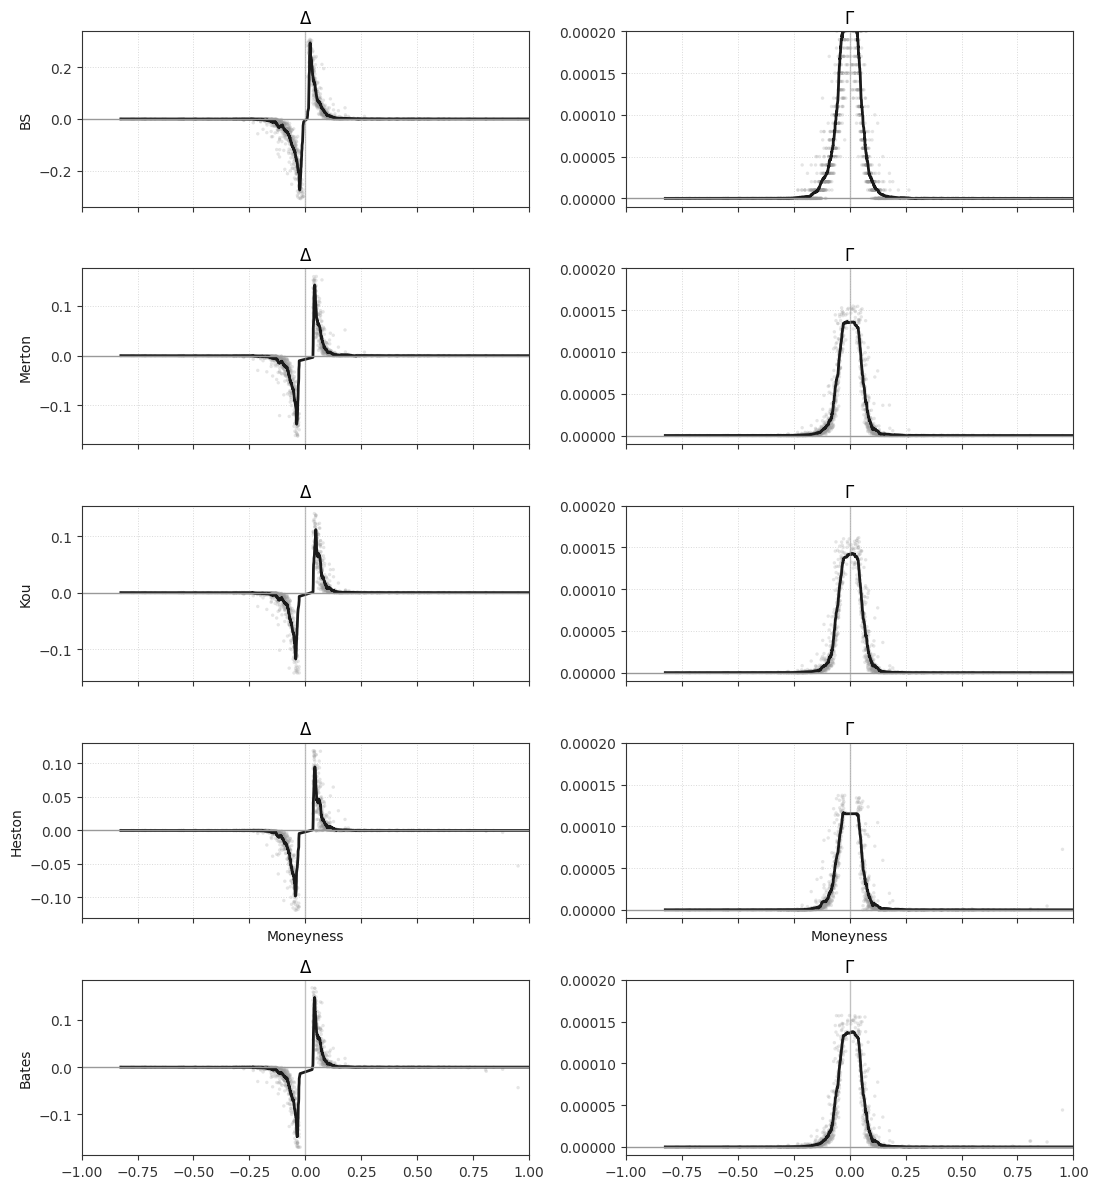

In [ ]:
MODELS   = ["BS", "merton","kou","heston","bates"]
DATA_DIR = Path("/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hedging/")

def smooth_series(y, frac=0.06, poly=3):
    y = np.asarray(y, float)
    n = len(y)
    win = max(5, int(np.ceil(frac * n)) | 1)
    if win >= n:
        return pd.Series(y).rolling(5, center=True, min_periods=1).median().to_numpy()
    return savgol_filter(y, window_length=win, polyorder=min(poly, win-1))

def winsor_mask(y, q=0.005):
    low, high = np.nanquantile(y, [q, 1-q])
    return (y >= low) & (y <= high)

def mad_mask(y, k=8.0):
    med = np.nanmedian(y)
    mad = np.nanmedian(np.abs(y - med)) + 1e-12
    z   = 0.6745 * (y - med) / mad
    return np.abs(z) <= k

def load_model_series(model):
    df = pd.read_csv(DATA_DIR / f"{model}_hedge_results.csv")
    delta_col = f"delta_{model}" if f"delta_{model}" in df.columns else "delta"
    gamma_col = f"gamma_{model}" if f"gamma_{model}" in df.columns else "gamma"
    use  = df[["moneyness_open", delta_col, gamma_col]].dropna().copy()
    use.sort_values("moneyness_open", inplace=True)

    moneyness = use["moneyness_open"].to_numpy()
    delta = use[delta_col].to_numpy()
    gamma = use[gamma_col].to_numpy()

    # Outlier filters (quantile + MAD, per series)
    mask_delta = winsor_mask(delta, q=0.01) & mad_mask(delta, k=8.0)
    mask_gamma = winsor_mask(gamma, q=0.01) & mad_mask(gamma, k=8.0)

    return moneyness, delta, gamma, mask_delta, mask_gamma

plt.rcParams.update({
    "axes.edgecolor": "0.2",
    "axes.labelcolor": "0.1",
    "xtick.color": "0.2",
    "ytick.color": "0.2",
})

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(11, 12), sharex=True)
for r, model in enumerate(MODELS):
    moneyness, delta, gamma, mask_delta, mask_gamma = load_model_series(model)

    # smooth on filtered data
    delta_smooth = smooth_series(delta[mask_delta], frac=0.06, poly=2)
    gamma_smooth = smooth_series(gamma[mask_gamma], frac=0.10, poly=2)

    delta_smooth[np.abs(moneyness[mask_delta]) >= 0.40] = 0.0
    gamma_smooth[np.abs(moneyness[mask_gamma]) >= 0.40] = 0.0

    # delta subplot
    ax = axes[r, 0]
    ax.title.set_text(r"$\Delta$")
    ax.scatter(moneyness[mask_delta], delta[mask_delta], s=6, alpha=0.25, color="0.6", edgecolors="none")
    ax.plot(moneyness[mask_delta], delta_smooth, linewidth=2, color="0.1")
    ax.axhline(0, linewidth=1, color="0.6")
    ax.axvline(0, linewidth=1, color="0.6", alpha=0.6)
    if model == "BS":
        ax.set_ylabel("BS")
    else:
        ax.set_ylabel(f"{model.capitalize()}")
    if r == 3: ax.set_xlabel("Moneyness")

    # gamma subplot
    ax = axes[r, 1]
    ax.title.set_text(r"$\Gamma$")
    ax.scatter(moneyness[mask_gamma], gamma[mask_gamma], s=6, alpha=0.25, color="0.6", edgecolors="none")
    ax.plot(moneyness[mask_gamma], gamma_smooth, linewidth=2, color="0.1")
    ax.set_ylim(-0.00001, 0.00020)
    ax.axhline(0, linewidth=1, color="0.6")
    ax.axvline(0, linewidth=1, color="0.6", alpha=0.6)
    if r == 3: ax.set_xlabel("Moneyness")

for c in range(2):
    for r in range(4):
        ax = axes[r, c]
        ax.grid(True, linestyle=":", linewidth=0.7, color="0.85")
        ax.set_xlim(-1.0, 1.0)   

plt.tight_layout()
plt.show()



Distribution of Quotes Across Moneyness Buckets
                  Count  % of Total Quotes
moneyness_bucket                          
(-inf, -1.00]         0              0.00%
(-1.00, -0.95]        0              0.00%
(-0.95, -0.90]        0              0.00%
(-0.90, -0.85]        0              0.00%
(-0.85, -0.80]        1              0.07%
(-0.80, -0.75]        2              0.13%
(-0.75, -0.70]        4              0.26%
(-0.70, -0.65]        2              0.13%
(-0.65, -0.60]        2              0.13%
(-0.60, -0.55]        4              0.26%
(-0.55, -0.50]        3              0.20%
(-0.50, -0.45]        6              0.40%
(-0.45, -0.40]        6              0.40%
(-0.40, -0.35]        7              0.46%
(-0.35, -0.30]       15              0.99%
(-0.30, -0.25]       32              2.11%
(-0.25, -0.20]       65              4.29%
(-0.20, -0.15]      104              6.86%
(-0.15, -0.10]      144              9.50%
(-0.10, -0.05]      168             11.09%
(-0.0

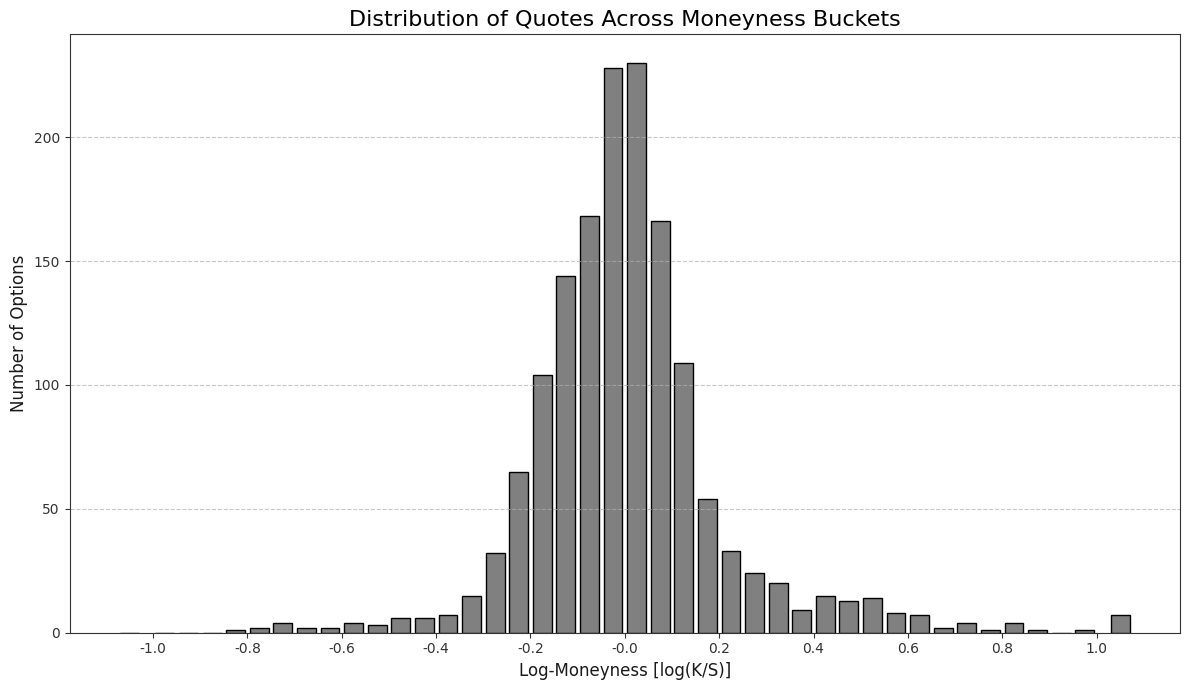

In [ ]:
model = 'merton' 
file_path = f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hedging/Data/{model}_hedge_results.csv'
df = pd.read_csv(file_path)

core_bins = np.arange(-1.0, 1.05, 0.05)
bins = np.concatenate(([-np.inf], core_bins, [np.inf]))
labels = []
for i in range(len(bins) - 1):
    if i == 0:
        label = f"(-inf, {bins[i+1]:.2f}]"
    elif i == len(bins) - 2:
        label = f"({bins[i]:.2f}, inf)"
    else:
        label = f"({bins[i]:.2f}, {bins[i+1]:.2f}]"
    labels.append(label)

df['moneyness_bucket'] = pd.cut(df['moneyness_open'], bins=bins, labels=labels, right=True)
bucket_counts = df['moneyness_bucket'].value_counts().sort_index()
total_quotes = len(df)
quote_percentages = (bucket_counts / total_quotes * 100)

results_df = pd.DataFrame({
    'Count': bucket_counts,
    '% of Total Quotes': quote_percentages
})

print("\n" + "="*50)
print("Distribution of Quotes Across Moneyness Buckets")
print("="*50)
print(results_df.to_string(float_format="%.2f%%"))
print("-" * 50)
print(f"Total Quotes Analyzed: {total_quotes}")
print("="*50)


midpoints = (bins[:-1] + bins[1:]) / 2
midpoints[0] = bins[1] - 0.05   # e.g., -1.05
midpoints[-1] = bins[-2] + 0.05 # e.g.,  1.05

tick_locations = np.arange(-1.0, 1.1, 0.2)
tick_labels = [f'{tick:.1f}' for tick in tick_locations]

plt.figure(figsize=(12, 7))
plt.bar(midpoints, results_df['Count'].values, width=0.04, color='gray', edgecolor='black')
plt.xticks(tick_locations, tick_labels)
plt.title('Distribution of Quotes Across Moneyness Buckets', fontsize=16)
plt.xlabel('Log-Moneyness [log(K/S)]', fontsize=12)
plt.ylabel('Number of Options', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()